<a href="https://colab.research.google.com/github/Harpreet24/Handwritten-digit-GAN/blob/main/HandwrittendigitsusingGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
from numpy import random
from numpy import vstack
import pandas as pd
import os
#print(os.listdir("/content/train.csv"))
import matplotlib.pyplot as plt
from PIL import Image

In [22]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.models import load_model

In [24]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
X_train = train_df.drop(['label'], axis=1).values
X_test = test_df.values
X = np.concatenate((X_train, X_test))
X = X / 255. # standardize the values in the datasets by dividing by 255
print(X.shape)

(70000, 784)


In [25]:
nX = 28     # size of image nX by nX
nC = 1      # number of channels
X = X.reshape((-1, nX, nX, nC))
print(X.shape)

(70000, 28, 28, 1)


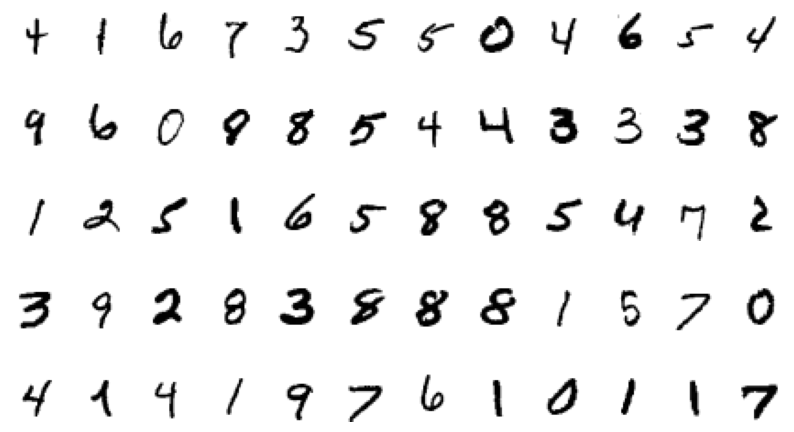

In [26]:
# pick some random digits from the dataset X and look at them
plt.figure(figsize=(10,6))
n_digits = 60
select = random.randint(low=0,high=X.shape[0],size=n_digits)
for i, index in enumerate(select):
    plt.subplot(5, 12, i+1)
    plt.imshow(X[index].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

The Discriminator

The discriminator takes a sample "digit" from our dataset and says whether it is real or fake.

Inputs: "digit" 28x28 pixels in size; one channel.

Outputs: binary classification, likelihood the sample is real.

Define the Discriminator

In [27]:
def define_discriminator(in_shape=(nX,nX,nC)):
    """
    Define the conv net for the discriminator
    """
    model = Sequential()
    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same',input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(rate=0.4))
    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(rate=0.4))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    opt = Adam(lr=0.0002,beta_1=0.5) # define optimizer
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

In [28]:
discriminator = define_discriminator()
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 3136)             

Training of the Discriminator

All "digit" samples will be labelled '1' (real). Need to create fake samples labelled as '0'. The fake samples will be created by the Generator. The real and fake samples will be fed into the Discriminator by batches.

In [29]:
def generate_real_samples(data, n_samples):
    """
    Pick 'n_samples' randomly from 'data'
    """
    idx = random.randint(low=0,high=data.shape[0],size=n_samples)
    X = data[idx]
    Y = np.ones((n_samples,1))
    return X, Y

 The Generator

The Generator creates new, fake but plausible images. It works by taking a point from a latent space as input and output an image.

Inputs: Point in latent space, e.g. a 100-element vector of Gaussian random numbers.

Outputs: 2D image of 28x28 pixels with pixel values in [0, 1].

In [30]:
def define_generator(latent_dim):
    """
    Define the conv net for the generator
    """
    n_nodes = 128*7*7
    model = Sequential()
    model.add(Dense(n_nodes,input_dim=latent_dim)) # foundation for 7*7 image
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,128)))
    model.add(Conv2DTranspose(128,kernel_size=4,strides=2,padding='same')) # up-sample to 14*14 image
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128,kernel_size=4,strides=2,padding='same')) # up-sample to 28*28 image
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1,kernel_size=7,activation='sigmoid',padding='same'))
    return model

In [31]:
latent_dim = 100 # define size of latent space
generator = define_generator(latent_dim)
generator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 14, 14, 128)       262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 28, 28, 128)       262272    
 Transpose)                                           

In [32]:
def generate_latent_points(latent_dim, n_samples):
    """
    This generates points in the latent space as input for the generator
    """
    x_input = random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)     # reshape into a batch of inputs for the network
    return x_input

In [33]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    """
    Generate 'n_samples' of fake samples from the generator
    """
    X_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(X_input)    # generator predicts output
    Y = np.zeros((n_samples,1))     # create class labels '0' for fake sample
    return X, Y

Combining the Discriminator & Generator as a GAN

In [34]:
def define_gan(g_model, d_model):
    """
    This takes as arguments the generator and discriminator and creates the GAN subsuming these two models.
    The weights in the discriminator are marked as not trainable,
    which only affects the weights as seen by the GAN and not the standalone discriminator model.
    """
    d_model.trainable = False     # make weights in the discriminator not trainable
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [35]:
gan = define_gan(generator, discriminator)
gan.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential_6 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 1204994 (4.60 MB)
Trainable params: 1164289 (4.44 MB)
Non-trainable params: 40705 (159.00 KB)
_________________________________________________________________


Functions to evaluate performance of GAN

In [36]:
def save_plot(examples, epoch, n=10):
    """
    This creates and save a plot of generated images
    """
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap=plt.cm.binary)
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [37]:
def summarize_performance(epoch, g_model, d_model, data, latent_dim, n_samples=100):
    """
    This evaluates the discriminator, plot generated images, save generator model
    """
    X_real, Y_real = generate_real_samples(data, n_samples)
    _, acc_real = d_model.evaluate(X_real, Y_real, verbose=0)   # evaluate discriminator on real samples
    X_fake, Y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(X_fake, Y_fake, verbose=0)   # evaluate discriminator on fake samples
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))    # summarize discriminator performance
    save_plot(X_fake, epoch)
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

Train the GAN

In [38]:
def train(g_model, d_model, gan_model, data, latent_dim, n_epochs=100, batch_size=256):
    """
    This trains the combined generator and discriminator models in the GAN
    """
    batch_per_epoch = data.shape[0] // batch_size
    half_batch = batch_size // 2
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real, Y_real = generate_real_samples(data, half_batch)   # randomly select real samples
            X_fake, Y_fake = generate_fake_samples(g_model, latent_dim, half_batch)   # generate fake samples
            X, Y = vstack((X_real, X_fake)), vstack((Y_real, Y_fake))  # create training set for discriminator
            d_loss, _ = d_model.train_on_batch(X, Y)   # update discriminator model weights
            X_gan = generate_latent_points(latent_dim, batch_size)   # as input for generator
            Y_gan = np.ones((batch_size, 1))
            g_loss = gan_model.train_on_batch(X_gan, Y_gan)   # update generator via the discriminator's error
            # print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, batch_per_epoch, d_loss, g_loss)) # summarize loss for batch
        # evaluate the model performance, after some epochs
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, data, latent_dim)

In [39]:
latent_dim = 50
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
data = X
train(g_model, d_model, gan_model, data, latent_dim)

4/4 [==============================] - 0s 4ms/step
>Accuracy real: 92%, fake: 21%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 3ms/step
>Accuracy real: 23%, fake: 89%


4/4 [==============================] - 0s 4ms/step
>Accuracy real: 49%, fake: 65%


4/4 [==============================] - 0s 3ms/step
>Accuracy real: 84%, fake: 23%


4/4 [==============================] - 0s 3ms/step
>Accuracy real: 12%, fake: 95%


4/4 [==============================] - 0s 3ms/step
>Accuracy real: 31%, fake: 84%


4/4 [==============================] - 0s 4ms/step


KeyboardInterrupt: 

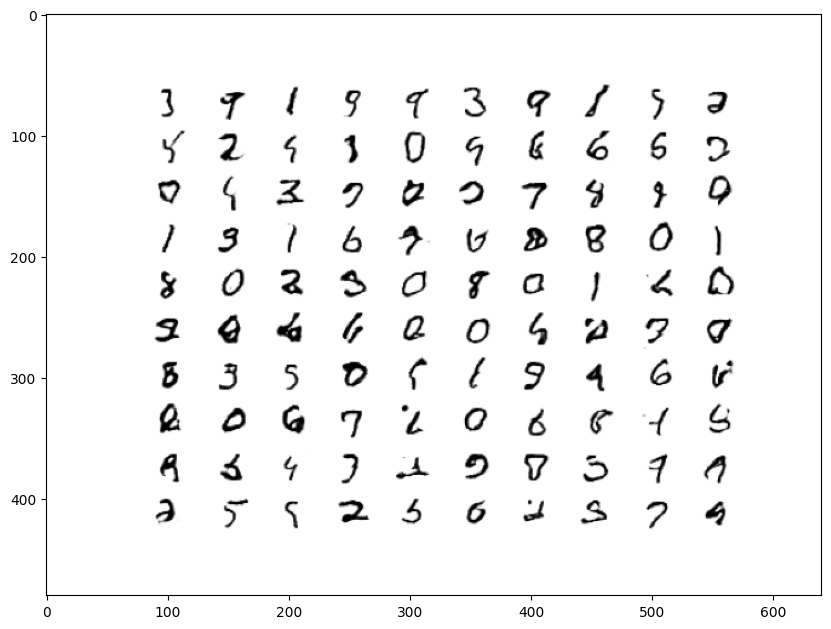

In [44]:
img = Image.open('/content/generated_plot_e060.png')
plt.figure(figsize = (10,10))
plt.imshow(img)

**Using the final Generator model to generate images**

The generation of each image requires a point in the latent space as input.

In [45]:
def show_plot(examples, n):
    """
    This shows the plots from the GAN
    """
    plt.figure(figsize=(10,10))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap=plt.cm.binary)
    plt.show()

2/2 [==============================] - 0s 5ms/step


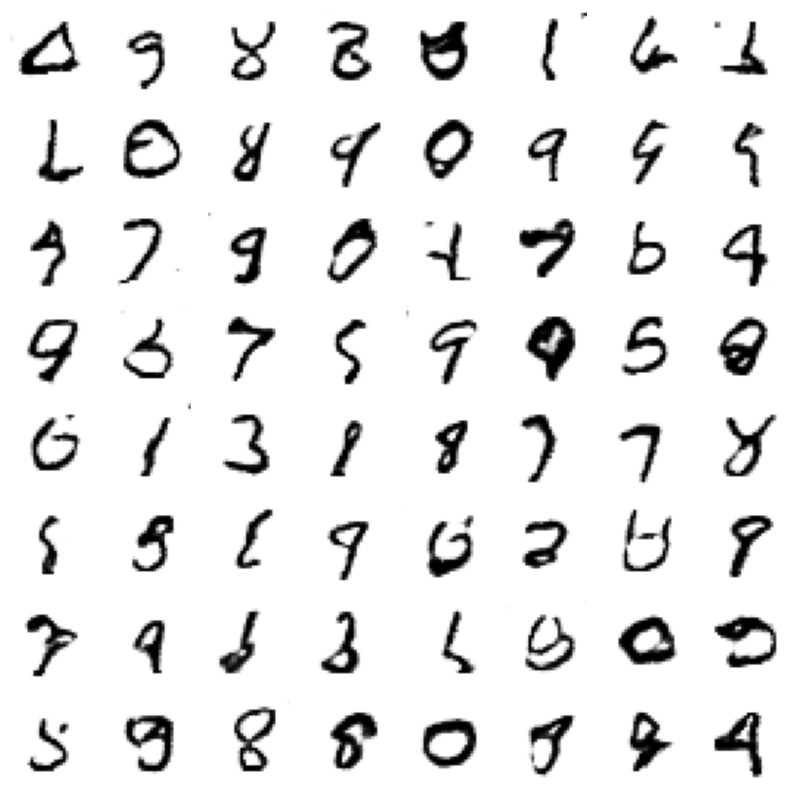

In [47]:
latent_points = generate_latent_points(50, 64)
new_digits = g_model.predict(latent_points)
show_plot(new_digits, 8)